# Start with WISE

In [328]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error


h = pd.read_csv('../data/holidays.csv')

# create a pandas dataframe object
df = pd.read_csv('../data/WISE-Contractual_aht_vol.csv', index_col=0,
                 parse_dates=['date'])

# create column for aht
df['aht'] = df['handle_time']/df['volume']
df['aht_forecast'] = df['handle_time_forecast']/df['volume_forecast']


df.index = df['date']
display(df.head())

df1 = df.copy()

,date,handle_time,handle_time_forecast,volume,volume_forecast,aht,aht_forecast
date,,,,,,,
2016-01-01,2016-01-01,0.0,NaN,0.0,0.0,NaN,NaN
2016-01-02,2016-01-02,0.0,NaN,0.0,0.0,NaN,NaN
2016-01-03,2016-01-03,0.0,NaN,0.0,0.0,NaN,NaN
2016-01-04,2016-01-04,6893852.0,NaN,10210.0,9930.0,675.205877,NaN
2016-01-05,2016-01-05,4866501.0,NaN,7110.0,9572.0,684.458650,NaN


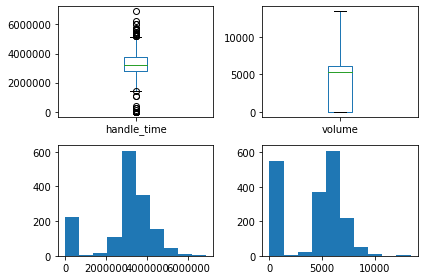

In [329]:
plt.subplot(221)
df['handle_time'].plot.box()

plt.subplot(222)
df['volume'].plot.box()

plt.subplot(223)
df['handle_time'].hist(grid=False)

plt.subplot(224)
df['volume'].hist(grid=False)
plt.tight_layout()
plt.show()

# Date Range

In [330]:
print('Start:', df['date'].min())
print('End:', df['date'].max())

df['month'] = df['date'].dt.month_name()
df['year'] = df['date'].dt.year

Start: 2016-01-01 00:00:00
End: 2021-01-25 00:00:00


# Holidays and weekends

In [331]:
df['date'].dt.weekday.isin([5,6]).any(),df['date'].isin(h.iloc[:,0].tolist()).any()

(True, True)

In [332]:
df = df[(~df['date'].dt.weekday.isin([5,6]))  & (~df['date'].isin(h.iloc[:,0].tolist()))]

# Check holidays and weekends are removed from training data

In [333]:
df['date'].dt.weekday.isin([5,6]).any(),df['date'].isin(h.iloc[:,0].tolist()).any()

(False, False)

In [334]:
df.isna().sum()

date                       0
handle_time                0
handle_time_forecast    1119
volume                     0
volume_forecast            0
aht                        6
aht_forecast            1119
month                      0
year                       0
dtype: int64

# days of null aht are due to zero handle time and volume

In [335]:
display(df[df['handle_time'] < 100000])

,date,handle_time,handle_time_forecast,volume,volume_forecast,aht,aht_forecast,month,year
date,,,,,,,,,
2016-01-01,2016-01-01,0.0,NaN,0.0,0.0,NaN,NaN,January,2016
2016-05-30,2016-05-30,0.0,NaN,0.0,0.0,NaN,NaN,May,2016
2016-07-04,2016-07-04,0.0,NaN,0.0,0.0,NaN,NaN,July,2016
2016-09-05,2016-09-05,0.0,NaN,0.0,0.0,NaN,NaN,September,2016
2016-11-24,2016-11-24,0.0,NaN,0.0,0.0,NaN,NaN,November,2016
2016-12-26,2016-12-26,0.0,NaN,0.0,0.0,NaN,NaN,December,2016


In [336]:
(df[df['aht'].isna()]['date'] == df[df['handle_time'] < 100000]['date']).all()

True

In [337]:
null_dates = df[df['aht'].isna()]['date'].tolist()

# Remove these dates

In [338]:
df = df[~df['date'].isin(null_dates)]

# Analyze volume

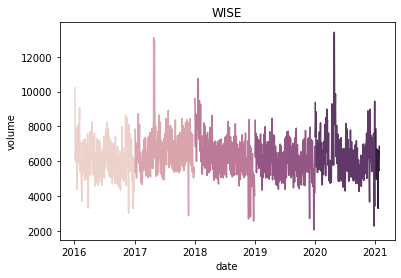

In [339]:
ax = sns.lineplot(x='date', y='volume', hue='year', data=df)
plt.title('WISE')
ax.get_legend().remove()
plt.show()

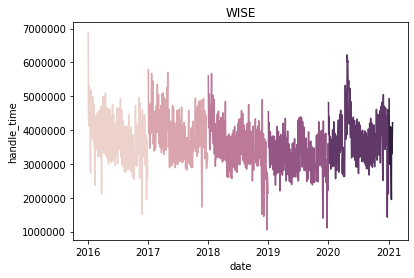

In [340]:
ax = sns.lineplot(x='date', y='handle_time', hue='year', data=df)
plt.title('WISE')
ax.get_legend().remove()
plt.show()

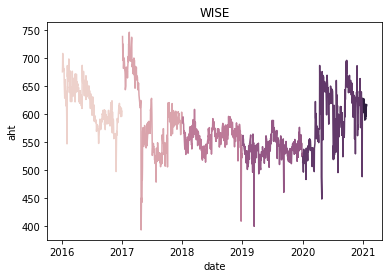

In [341]:
ax = sns.lineplot(x='date', y='aht', hue='year', data=df)
plt.title('WISE')
ax.get_legend().remove()
plt.show()

# What are all these outlier low points?

In [342]:
df[df['handle_time'] < 2000000]

,date,handle_time,handle_time_forecast,volume,volume_forecast,aht,aht_forecast,month,year
date,,,,,,,,,
2016-11-25,2016-11-25,1503466.0,NaN,3025.0,2878.0,497.013554,NaN,November,2016
2016-12-23,2016-12-23,1955335.0,NaN,3285.0,4221.0,595.231355,NaN,December,2016
2017-11-24,2017-11-24,1721865.0,NaN,2872.0,3281.0,599.535167,NaN,November,2017
2018-11-23,2018-11-23,1504823.0,NaN,2690.0,2549.0,559.413755,NaN,November,2018
2018-12-05,2018-12-05,1449824.0,NaN,2810.0,3328.0,515.951601,NaN,December,2018
2018-12-24,2018-12-24,1047946.0,NaN,2566.0,2827.0,408.396726,NaN,December,2018
2019-11-29,2019-11-29,1396417.0,NaN,2710.0,2750.0,515.283026,NaN,November,2019
2019-12-24,2019-12-24,1106389.0,NaN,2058.0,2333.0,537.603984,NaN,December,2019
2020-12-24,2020-12-24,1425097.0,1454898.0,2281.0,2227.0,624.768523,653.299506,December,2020


In [219]:
df = df[df['handle_time'] > 2000000]

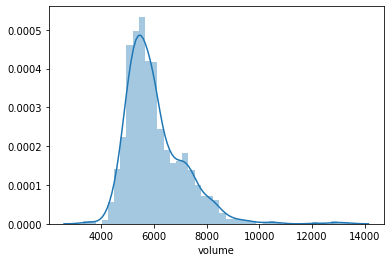

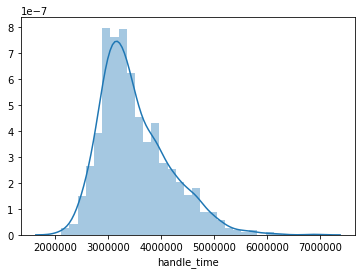

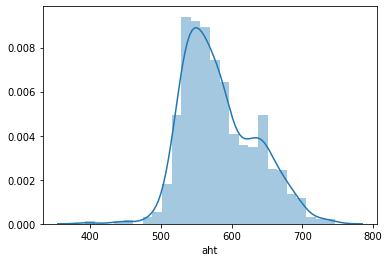

In [220]:
for k in ['volume', 'handle_time', 'aht']:
    sns.distplot(df[k])
    plt.show()

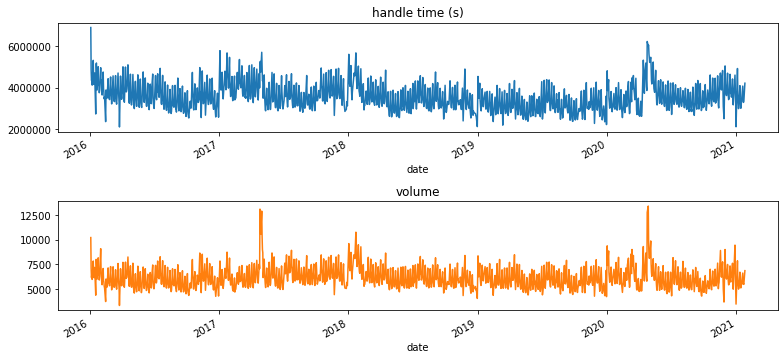

In [221]:
plt.figure(figsize=(11,7))
plt.subplot(311)
df['handle_time'].plot(color='#1f77b4')
plt.title('handle time (s)')
plt.subplot(312)
df['volume'].plot(color='#ff7f0e')
plt.title('volume')
plt.tight_layout()
plt.show()

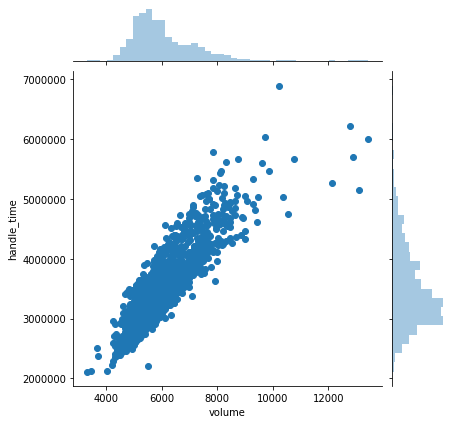

In [222]:
_ = sns.jointplot(x='volume', y='handle_time', data=df)

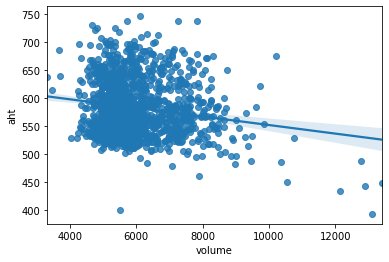

In [223]:
_ = sns.regplot(data=df,x='volume', y='aht' )

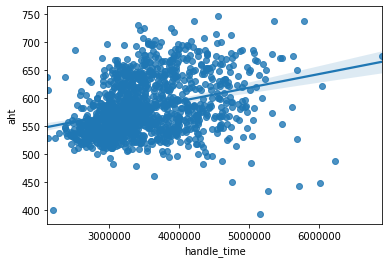

In [224]:
_ = sns.regplot(data=df,x='handle_time', y='aht' )

In [225]:
# validate aht forecast is only null where handle_time_forecast is null 
(df[df['handle_time_forecast'].notnull()].index == df[df['aht_forecast'].notnull()].index).all()

True

In [226]:
df[df['aht_forecast'].notnull()].head(1)

,date,handle_time,handle_time_forecast,volume,volume_forecast,aht,aht_forecast,month,year
date,,,,,,,,,
2020-06-01,2020-06-01,4383284.0,5446214.0,6735.0,7870.0,650.821678,692.022109,June,2020


In [227]:
df[['volume', 'handle_time', 'aht']].describe()

,volume,handle_time,aht
count,1269.000000,1.269000e+03,1269.000000
mean,6033.085894,3.501136e+06,581.932175
std,1126.427520,6.557845e+05,50.780812
min,3313.000000,2.113965e+06,392.733247
25%,5274.000000,3.028635e+06,543.466065
50%,5782.000000,3.351051e+06,572.274589
75%,6561.000000,3.882085e+06,618.583127
max,13410.000000,6.893852e+06,745.892016


# Step 3: Create Training Data and Fit Model for handle time
In order to train our model, we need to define a start and end date for the training data.
Typically, training should be performed with the most relevant or recent data.

In [228]:
## make a copy of original dataframe
df1 = df.copy()

In [229]:
## create new dataframe for prediction
df = df1[['handle_time']]

df = df.reset_index()

In [230]:
# Must pre-format column names
df.columns = ['ds','y']

In [231]:
# set start date of training data
df = df[(df['ds'] >= '2016-03-10') & (df['ds'] < '2021-01-01')]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 48 to 1253
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1206 non-null   datetime64[ns]
 1   y       1206 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.3 KB


In [232]:
# create default prophet model
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
m.fit(df)

In [233]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1566,2021-12-27
1567,2021-12-28
1568,2021-12-29
1569,2021-12-30
1570,2021-12-31


In [234]:
# get rid of holidays and weekends
future = future[(~future['ds'].isin(h.iloc[:,0].tolist())) & (~future['ds'].dt.weekday.isin([5,6]))]

In [235]:
forecast = m.predict(future)

# view only the last 5 predictions with confidence intervals 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1461,2021-12-27,4.990752e+06,4.467066e+06,5.528630e+06
1462,2021-12-28,4.360225e+06,3.821921e+06,4.887660e+06
1463,2021-12-29,4.107982e+06,3.627072e+06,4.625881e+06
1464,2021-12-30,3.993846e+06,3.506816e+06,4.517352e+06
1465,2021-12-31,4.064811e+06,3.557519e+06,4.606526e+06


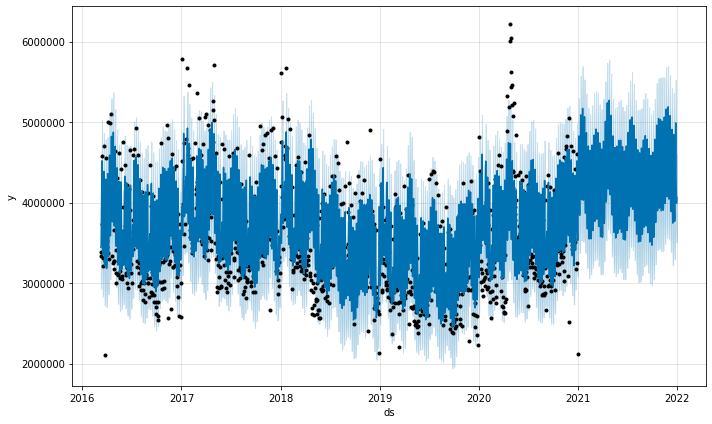

In [236]:
fig1 = m.plot(forecast)

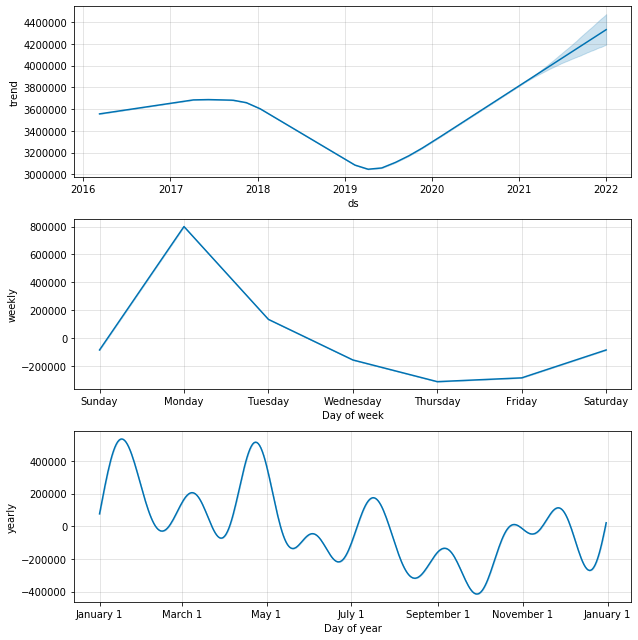

In [237]:
fig2 = m.plot_components(forecast)

In [238]:
# # set forecast beginning and end date
# f = forecast.copy()
# f = f[(forecast['ds'] >= '2020-06-01') & (f['ds'] < '2021-01-18')]

# # create validation dataset
# # set start date of validation data equal to January 1st, 2020
# df2 = df1.copy()
# df2 = df2[df2['date'] >= '2020-06-01']

In [239]:
# def validate_dates(f, df2):
#     """
#     take in forecast, f
#     and dataframe df2 and return Bool
#     """
#     res = []
#     # validate forecast dates shape equals actual dates shape
#     v1 = df2.shape[0] == f.shape[0]
#     if not v1:
#         return False
#     else: res.append(v1)
        
#     # validate all dates for forecast equal actual dates
#     res.append(all(df2['date'].dt.date.values == f['ds'].dt.date.values))
    
#     return all(res)

# print(validate_dates(f, df2))

False


In [240]:
# from sklearn.metrics import mean_absolute_error

# mae1 = mean_absolute_error(df2['handle_time'], df2['handle_time_forecast'])
# mae2 = mean_absolute_error(df2['handle_time'], f['yhat'])
# diff = mae1- mae2
# pd.DataFrame(index=['old model', 'prophet', 'difference'], 
#              data=[int(mae1), int(mae2), int(diff)],
#              columns=['MAE'])

In [241]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error

In [252]:
def load_data(path):
    """
    using a path to a bu dataset return the dataframe
    """
    # create a pandas dataframe object
    df = pd.read_csv('../data/'+path, index_col=0,
                     parse_dates=['date'])

    # create column for aht
    df['aht'] = df['handle_time']/df['volume']
    df['aht_forecast'] = df['handle_time_forecast']/df['volume_forecast']


    df.index = df['date']
    return df

In [253]:
def remove_holidays(df, path='../data/holidays.csv'):
    """
    take in a holidays csv of dates and return
    a filtered dataframe
    """
    
    holidays = pd.read_csv(path)
    
    if 'ds' not in df.columns:
        date_marker = 'date'
    else:
        date_marker = 'ds'
    
    return df[(~df[date_marker].dt.weekday.isin([5,6])) & (~df[date_marker].isin(holidays.iloc[:,0].tolist()))]

In [254]:
def clean_training_data(df, holidays=False):
    """
    take in a dataframe and return a filtered dataframe
    """
    
    # remove holidays and weekends
    if not holidays:
        df = remove_holidays(df)
    
    ## remove zeros
    df = df[df['handle_time'] > 10000]
    
    # remove nulls
    df = df[df['aht'].notnull()]

    return df

In [255]:
def create_training_data(df, metric, start='2016-01-01', end='2020-06-01'):
    """
    takes in a dataframe and returns a filtered dataframe
    """
    
    df = df[(df['date'] >= start) & (df['date'] < end)]
    
    df = df[[metric]]
    df = df.reset_index()
    df.columns = ['ds', 'y']
    return df

In [256]:
def train_model(df):
    """
    takes in a dataframe with 2 cols
    'ds' and 'y' and returns a prediction
    """
    # create default prophet model
    m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
    m.fit(df)
    
    return m


In [257]:
import datetime

def get_validation_data(df, end_training='2020-11-01', end_testing='2021-01-18'):
    """
    take in a dataframe and return a dataframe filtered after the end of training
    """
    df = remove_holidays(df)
    
    df = df[(df['date'] > end_training) & (df['date'] < end_testing)]
    
    return df



In [258]:
def get_accuracy(df2,forecast, kpi='handle_time'):
    mae1 = mean_absolute_error(df2[kpi], df2[kpi+'_forecast'])
    mae2 = mean_absolute_error(df2[kpi], forecast['yhat'])
    diff = mae1- mae2
    return pd.DataFrame(index=['old model', 'prophet', 'difference'], 
                 data=[int(mae1), int(mae2), int(diff)],
                 columns=['MAE'])

In [259]:
date_dict = {'BRO-Complex_aht_vol.csv':'2018-10-01', 'BRO_aht_vol.csv': '2018-11-01', 
    'CS-Alaska_aht_vol.csv':'2016-01-01', 'CS-John-Hancock_aht_vol.csv':'2019-12-01', 
    'CS-Maryland_aht_vol.csv': '2017-11-01', 'CS-National_aht_vol.csv':'2016-11-01', 
    'PSG_aht_vol.csv':'2019-11-01', 'RCS-PHONES_aht_vol.csv':'2018-11-01', 
    'RIS_aht_vol.csv':'2019-11-01', 'WISE-Contractual_aht_vol.csv':'2016-11-01'}

for k in ['volume', 'handle_time', 'aht']: 
    bu = 'WISE-Contractual_aht_vol.csv'
    kpi = k
    start_train = date_dict[bu]
    start_test = '2021-01-01'
    end_test = '2021-01-18'

    df = load_data(bu)

    df = clean_training_data(df)
    
    df2 = get_validation_data(df, end_training=start_test)

    df = create_training_data(df, kpi, start=start_train, end=start_test)

    m = train_model(df)
    future = m.make_future_dataframe(periods=365)
    future = remove_holidays(future)
    forecast = m.predict(future)

    forecast = forecast[(forecast['ds'] > start_test) & (forecast['ds'] < end_test)]

#     forecast = forecast.reset_index(drop=True)
#     df2 = df2.reset_index(drop=True)

    accuracy = get_accuracy(df2, forecast, kpi=kpi)

    print(bu,kpi)
    display(accuracy)

WISE-Contractual_aht_vol.csv volume


,MAE
old model,866
prophet,1101
difference,-234


WISE-Contractual_aht_vol.csv handle_time


,MAE
old model,850872
prophet,781217
difference,69655


WISE-Contractual_aht_vol.csv aht


,MAE
old model,48
prophet,29
difference,18


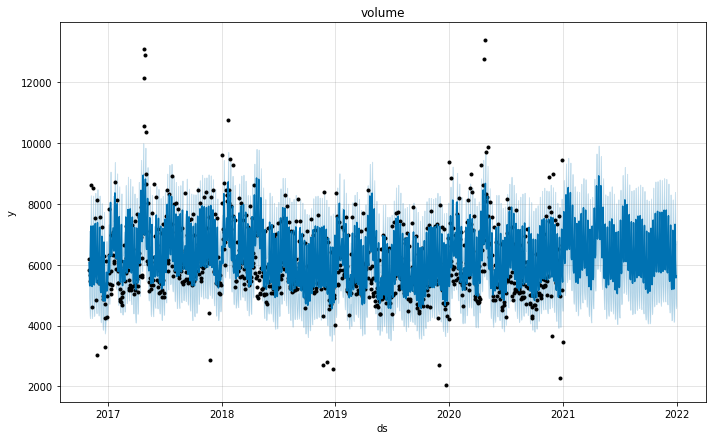

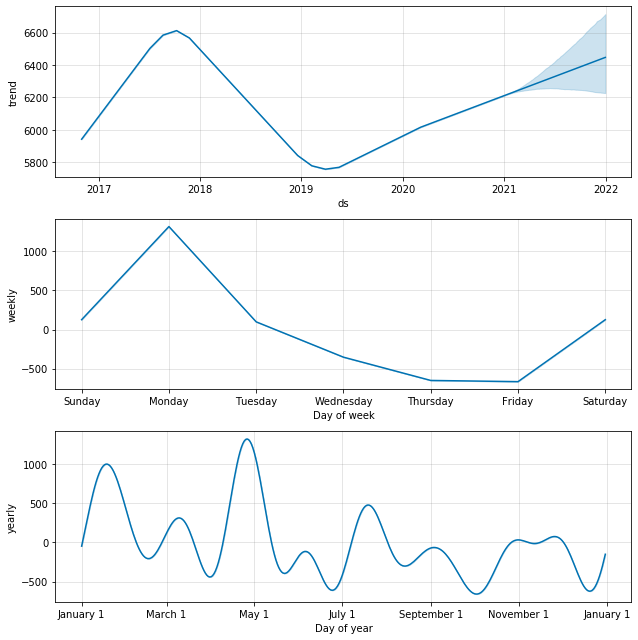

,ds,yhat_lower,yhat,yhat_upper,volume,volume_forecast,error_prophet,error_forecast,diff
0,2021-01-04,6741.804465,7747.016239,8784.186567,7850.0,9232.0,103.0,1382.0,1279.0
1,2021-01-05,5509.204117,6617.637977,7655.643382,5914.0,7145.0,704.0,1231.0,527.0
2,2021-01-06,5208.263713,6253.649769,7265.785152,5335.0,6629.0,919.0,1294.0,375.0
3,2021-01-07,5006.635909,6041.223292,7081.088995,4973.0,6150.0,1068.0,1177.0,109.0
4,2021-01-08,5097.000419,6107.411098,7146.675338,5102.0,6404.0,1005.0,1302.0,297.0
5,2021-01-11,7331.743890,8304.718599,9334.048570,6697.0,7084.0,1608.0,387.0,-1221.0
6,2021-01-12,6203.647962,7144.589256,8117.475672,5558.0,5924.0,1587.0,366.0,-1221.0
7,2021-01-13,5709.962619,6743.741873,7749.173601,5113.0,5625.0,1631.0,512.0,-1119.0
8,2021-01-14,5438.168733,6488.942888,7471.951968,5111.0,5584.0,1378.0,473.0,-905.0
9,2021-01-15,5516.643632,6507.914768,7600.543773,5495.0,6037.0,1013.0,542.0,-471.0


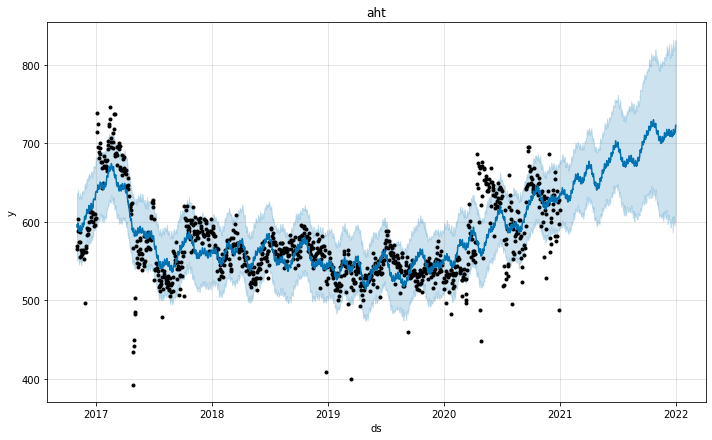

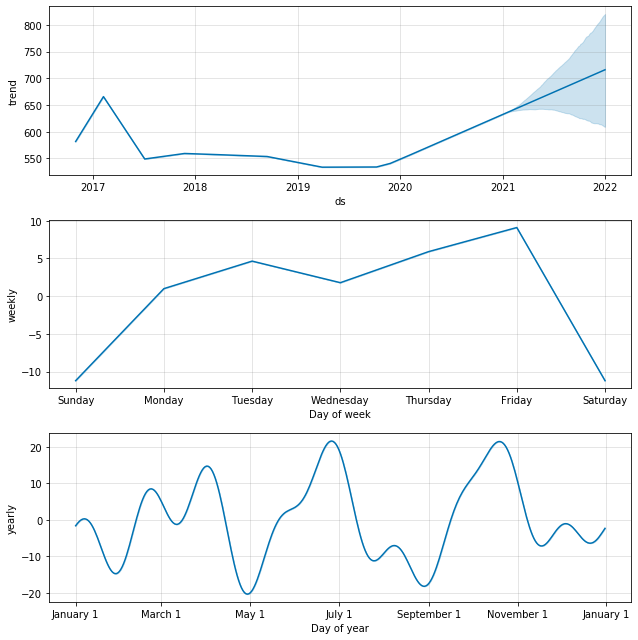

,ds,yhat_lower,yhat,yhat_upper,aht,aht_forecast,error_prophet,error_forecast,diff
0,2021-01-04,593.279608,633.901930,674.025231,627.262930,685.789211,7.0,59.0,52.0
1,2021-01-05,598.156518,638.070552,679.386253,627.241799,671.305248,11.0,44.0,33.0
2,2021-01-06,592.516176,635.618762,678.366147,609.397938,680.234274,26.0,71.0,45.0
3,2021-01-07,601.693114,640.026453,680.553198,602.155842,674.273008,38.0,72.0,34.0
4,2021-01-08,600.393749,643.384018,685.981670,626.527244,673.710337,17.0,47.0,30.0
5,2021-01-11,595.255580,634.948997,676.685752,612.149321,639.850508,23.0,28.0,5.0
6,2021-01-12,597.816939,638.225829,680.953048,598.557575,631.125928,40.0,33.0,-7.0
7,2021-01-13,592.585636,634.870345,676.569714,588.860552,640.881067,46.0,52.0,6.0
8,2021-01-14,595.372774,638.385485,679.694865,591.593817,632.410100,47.0,41.0,-6.0
9,2021-01-15,598.790091,640.884930,682.826620,597.170701,632.885374,44.0,36.0,-8.0


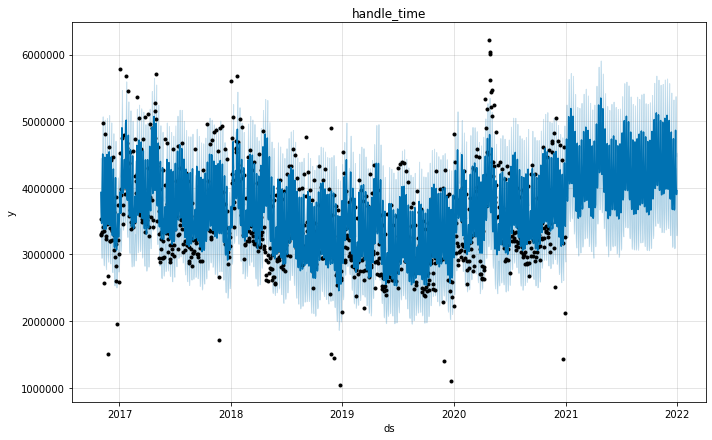

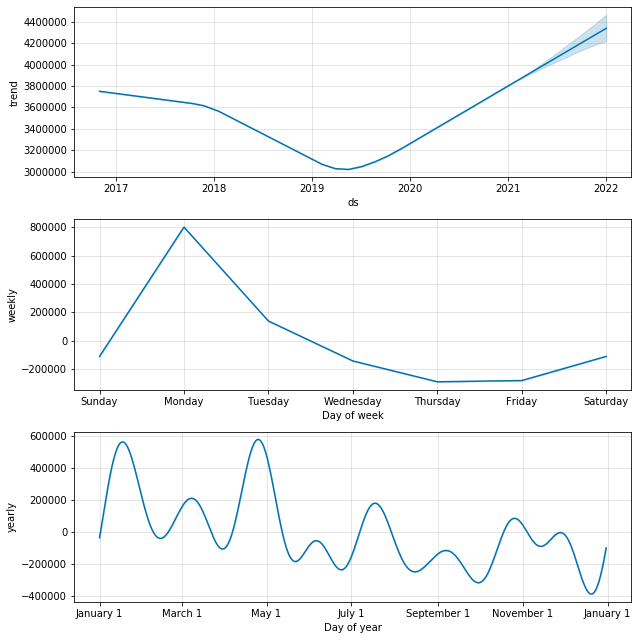

,ds,yhat_lower,yhat,yhat_upper,handle_time,handle_time_forecast,error_prophet,error_forecast,diff
0,2021-01-04,4.184098e+06,4.731718e+06,5.249903e+06,4924014.0,6331206.0,192296.0,1407192.0,1214896.0
1,2021-01-05,3.600106e+06,4.123993e+06,4.663823e+06,3709508.0,4796476.0,414485.0,1086968.0,672483.0
2,2021-01-06,3.337840e+06,3.895785e+06,4.439448e+06,3251138.0,4509273.0,644647.0,1258135.0,613488.0
3,2021-01-07,3.259084e+06,3.800462e+06,4.358732e+06,2994521.0,4146779.0,805941.0,1152258.0,346317.0
4,2021-01-08,3.365077e+06,3.858159e+06,4.432204e+06,3196542.0,4314441.0,661617.0,1117899.0,456282.0
5,2021-01-11,4.537536e+06,5.066745e+06,5.632543e+06,4099564.0,4532701.0,967181.0,433137.0,-534044.0
6,2021-01-12,3.883327e+06,4.437556e+06,4.960292e+06,3326783.0,3738790.0,1110773.0,412007.0,-698766.0
7,2021-01-13,3.651373e+06,4.184142e+06,4.717925e+06,3010844.0,3604956.0,1173298.0,594112.0,-579186.0
8,2021-01-14,3.541213e+06,4.060317e+06,4.619116e+06,3023636.0,3531378.0,1036681.0,507742.0,-528939.0
9,2021-01-15,3.501958e+06,4.086708e+06,4.595264e+06,3281453.0,3820729.0,805255.0,539276.0,-265979.0


Mean Absolute Error


,volume,aht,handle_time
old model,866,48,850872
prophet,1101,29,781217
difference,-234,18,69655


In [372]:
get_performance(['WISE-Contractual_aht_vol.csv'], ['volume', 'aht','handle_time'], '2021-01-01', '2021-01-18')

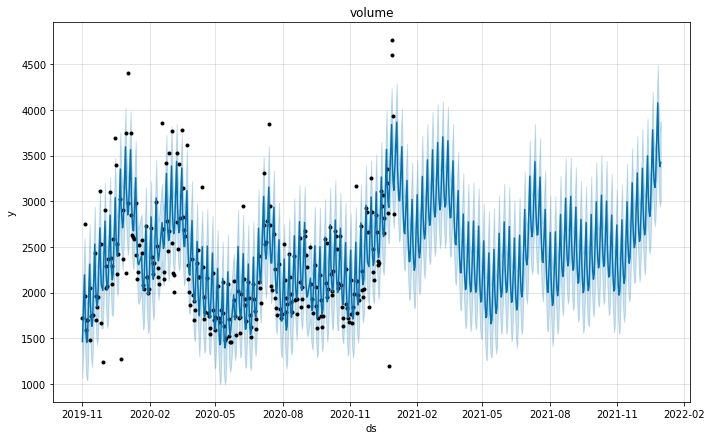

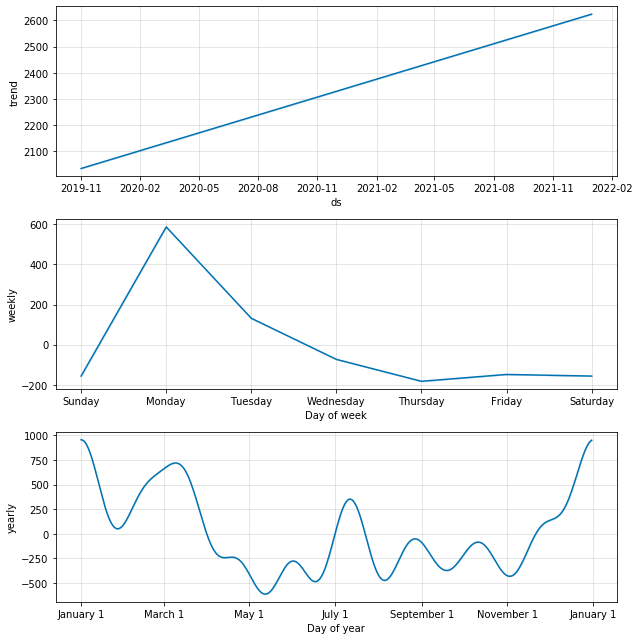

,ds,yhat_lower,yhat,yhat_upper,volume,volume_forecast,error_prophet,error_forecast,diff
0,2021-01-04,3460.597691,3866.838976,4290.131835,7230.0,4417.0,3363.0,2813.0,-550.0
1,2021-01-05,2950.606153,3388.205111,3790.259713,5657.0,3471.0,2269.0,2186.0,-83.0
2,2021-01-06,2751.929047,3154.346651,3574.166824,4899.0,3226.0,1745.0,1673.0,-72.0
3,2021-01-07,2559.803653,3010.502143,3421.405662,5169.0,3127.0,2158.0,2042.0,-116.0
4,2021-01-08,2570.145747,3004.973132,3401.919676,4853.0,3146.0,1848.0,1707.0,-141.0
5,2021-01-11,3220.692733,3598.203642,4015.555001,5912.0,5462.0,2314.0,450.0,-1864.0
6,2021-01-12,2650.399834,3089.001715,3505.480767,5319.0,4403.0,2230.0,916.0,-1314.0
7,2021-01-13,2409.157470,2829.413705,3234.960556,4354.0,4019.0,1525.0,335.0,-1190.0
8,2021-01-14,2266.474958,2665.126907,3073.707351,4115.0,3883.0,1450.0,232.0,-1218.0
9,2021-01-15,2240.180657,2644.782133,3040.928185,3928.0,3959.0,1283.0,31.0,-1252.0


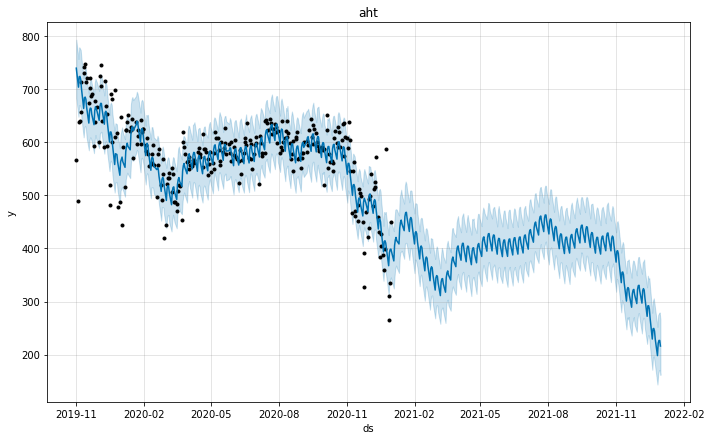

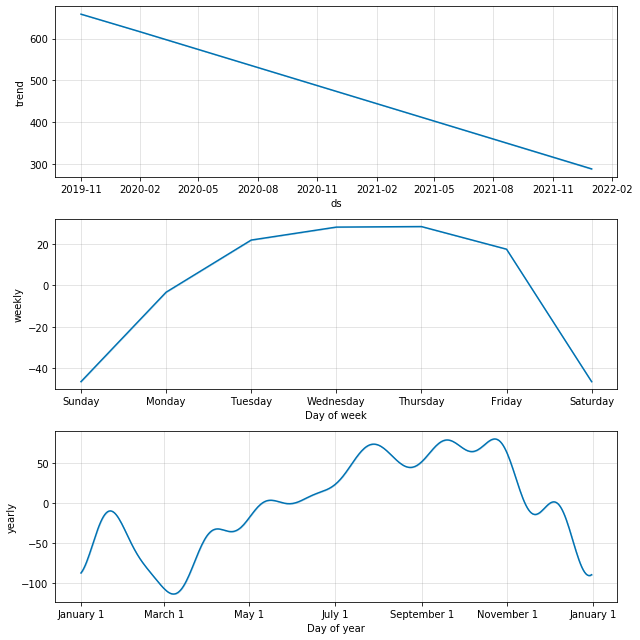

,ds,yhat_lower,yhat,yhat_upper,aht,aht_forecast,error_prophet,error_forecast,diff
0,2021-01-04,324.605277,376.563454,432.560269,180.961826,756.028526,196.0,575.0,379.0
1,2021-01-05,348.336931,405.593118,457.042647,283.609157,747.890810,122.0,464.0,342.0
2,2021-01-06,362.402514,416.065309,473.236255,275.490304,745.205518,141.0,470.0,329.0
3,2021-01-07,367.898598,420.857028,474.023391,278.565487,743.086345,142.0,465.0,323.0
4,2021-01-08,363.841955,414.668693,473.046446,313.355450,744.085188,101.0,431.0,330.0
5,2021-01-11,353.818218,408.486634,462.221633,259.203146,827.969059,149.0,569.0,420.0
6,2021-01-12,383.622155,438.415825,496.439566,302.175033,819.094935,136.0,517.0,381.0
7,2021-01-13,392.899159,449.121305,502.681191,365.205788,813.937795,84.0,449.0,365.0
8,2021-01-14,394.218555,453.490108,510.772338,377.676063,809.057687,76.0,431.0,355.0
9,2021-01-15,395.443470,446.246046,500.083770,361.590886,806.025006,85.0,444.0,359.0


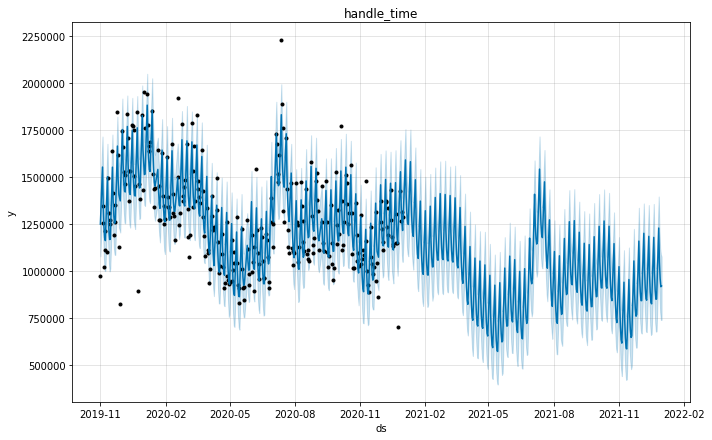

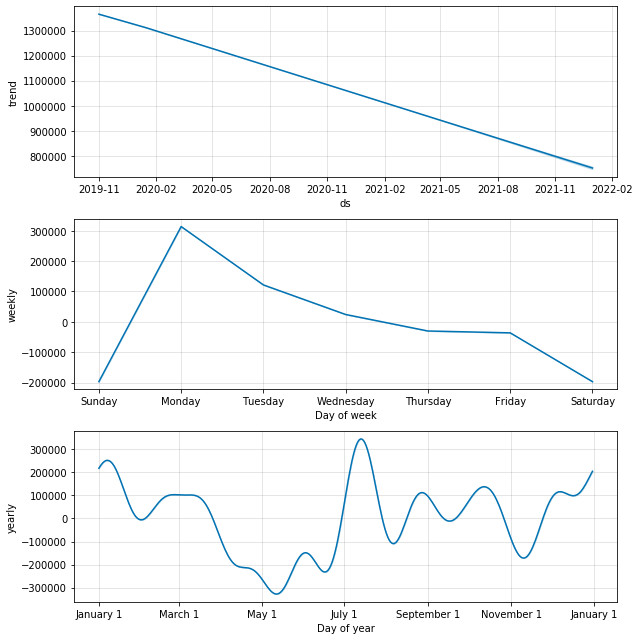

,ds,yhat_lower,yhat,yhat_upper,handle_time,handle_time_forecast,error_prophet,error_forecast,diff
0,2021-01-04,1.420108e+06,1.590018e+06,1.753468e+06,1308354.0,3339378.0,281664.0,2031024.0,1749360.0
1,2021-01-05,1.238914e+06,1.402310e+06,1.562568e+06,1604377.0,2595929.0,202067.0,991552.0,789485.0
2,2021-01-06,1.134707e+06,1.307642e+06,1.478058e+06,1349627.0,2404033.0,41985.0,1054406.0,1012421.0
3,2021-01-07,1.090060e+06,1.254065e+06,1.422458e+06,1439905.0,2323631.0,185840.0,883726.0,697886.0
4,2021-01-08,1.077632e+06,1.246735e+06,1.423762e+06,1520714.0,2340892.0,273979.0,820178.0,546199.0
5,2021-01-11,1.396996e+06,1.580548e+06,1.751816e+06,1532409.0,4522367.0,48139.0,2989958.0,2941819.0
6,2021-01-12,1.220921e+06,1.379118e+06,1.551715e+06,1607269.0,3606475.0,228151.0,1999206.0,1771055.0
7,2021-01-13,1.096696e+06,1.270697e+06,1.441102e+06,1590106.0,3271216.0,319409.0,1681110.0,1361701.0
8,2021-01-14,1.043133e+06,1.203639e+06,1.369299e+06,1554137.0,3141571.0,350498.0,1587434.0,1236936.0
9,2021-01-15,1.006586e+06,1.183393e+06,1.365443e+06,1420329.0,3191053.0,236936.0,1770724.0,1533788.0


Mean Absolute Error


,volume,aht,handle_time
old model,1238,481,1580931
prophet,2018,123,216866
difference,-779,358,1364064


In [371]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error
import datetime

def get_performance(data, fields, start, end):
    a = []
    date_dict = {'BRO-Complex_aht_vol.csv':'2018-10-01', 'BRO_aht_vol.csv': '2018-11-01', 
    'CS-Alaska_aht_vol.csv':'2016-01-01', 'CS-John-Hancock_aht_vol.csv':'2019-12-01', 
    'CS-Maryland_aht_vol.csv': '2017-11-01', 'CS-National_aht_vol.csv':'2016-11-01', 
    'PSG_aht_vol.csv':'2019-11-01', 'RCS-PHONES_aht_vol.csv':'2018-11-01', 
    'RIS_aht_vol.csv':'2019-11-01', 'WISE-Contractual_aht_vol.csv':'2016-11-01'}
    for b in data: 
        for k in fields:
            bu = b
            kpi = k
            start_train = date_dict[b]
            start_test = start
            end_test = end

            df = load_data(bu)

            df = clean_training_data(df)
            
            df2 = get_validation_data(df, end_training=start_test)

            df = create_training_data(df, kpi, start=start_train, end=start_test)

            m = train_model(df)

            future = m.make_future_dataframe(periods=365)
            future = remove_holidays(future)
            forecast = m.predict(future)
            
            fig1 = m.plot(forecast)
            plt.title(k)
            fig2 = m.plot_components(forecast)
            plt.show()

            f = forecast[(forecast['ds'] > start_test) & (forecast['ds'] < end_test)]
            
            f = f.reset_index(drop=True)
            df2 = df2.reset_index(drop=True)
            write_f = f[['ds','yhat_lower', 'yhat', 'yhat_upper']]
            
            write_f = pd.concat([write_f, df2[[k,k+'_forecast']]], 1)
            write_f['error_prophet'] = (write_f['yhat'] - write_f[k]).abs().round()
            write_f['error_forecast'] = (write_f[k+'_forecast'] - write_f[k]).abs().round()
            write_f['diff'] = write_f['error_forecast'] - write_f['error_prophet']
            display(write_f)
            write_f.to_csv('../preds/'+k+'_'+b[:6]+'.csv')

            accuracy = get_accuracy(df2, f, kpi=kpi)
            a.append(accuracy)

    diff = pd.concat([a[0], a[1], a[2]], axis=1)
    diff.columns = ['volume', 'aht', 'handle_time']
    diff.style.set_caption("Mean Absolute Error")
    print('Mean Absolute Error')
    display(diff)
    
get_performance(['RIS_aht_vol.csv'], ['volume', 'aht','handle_time'], '2021-01-01', '2021-01-18')